In [14]:
# !pip install rectools --ignore-installed --no-deps  # Сначала без зависимостей
# !pip install implicit

# Импорты

In [15]:
# Standard library imports
import os
import re
import pickle
import warnings
import textwrap
from pathlib import Path
from collections import Counter
from itertools import chain
from typing import (List, Dict, Optional, Tuple, Union, Any,
                   TypeVar, Callable, Iterable)
from urllib.request import urlopen
from io import BytesIO
import itertools

# Third-party general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
import threadpoolctl

# Machine learning and data processing
from sklearn.preprocessing import (StandardScaler, MultiLabelBinarizer,
                                 normalize)
from sklearn.cluster import (DBSCAN, AgglomerativeClustering)
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean
from scipy import sparse
from scipy.sparse import hstack, csr_matrix

# Deep learning and NLP
import torch
from sentence_transformers import SentenceTransformer
import timm

# Image processing
from PIL import Image
import requests

# Spark
import pyspark
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_timestamp

# Jupyter specific
from IPython.display import display, Markdown

# Suppress warnings
warnings.filterwarnings("ignore")

In [16]:
# Import libraries
from lightning_fabric import seed_everything
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback

import rectools
from rectools import Columns, ExternalIds
from rectools.dataset import Dataset
from rectools.metrics import NDCG, Recall, Serendipity, calc_metrics
from implicit.cpu.bpr import BayesianPersonalizedRanking
from rectools.models.implicit_bpr import ImplicitBPRWrapperModel
from implicit.cpu.als import AlternatingLeastSquares
from rectools.models.implicit_als import ImplicitALSWrapperModel
from rectools.models.nn.item_net import IdEmbeddingsItemNet
from rectools.models.nn.transformers.base import TransformerModelBase

from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import (
    MAP,
    CoveredUsers,
    AvgRecPopularity,
    Intersection,
    HitRate,
    Serendipity,
)
from rectools.model_selection import TimeRangeSplitter, cross_validate
from rectools.models.nn.item_net import CatFeaturesItemNet, IdEmbeddingsItemNet
from rectools.visuals import MetricsApp

warnings.simplefilter("ignore")

# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ['OPENBLAS_NUM_THREADS'] = '1'

# Random seed
RANDOM_STATE=60
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

60

# Функции

In [17]:
def leave_one_out_mask_for_users(interactions: pd.DataFrame) -> np.ndarray:
    rank = (
        interactions
        .sort_values(Columns.Datetime, ascending=False, kind="stable")
        .groupby(Columns.User, sort=False)
        .cumcount()
    )
    val_mask = (
        (interactions[Columns.User].isin(TEST_USERS))
        & (rank == 0)
    )
    return val_mask.values

# We do not use `partial` for correct serialization of the model
def get_val_mask_func(interactions: pd.DataFrame):
    return leave_one_out_mask_for_users(interactions)

In [18]:
# Implement custom Callback for RecTools metrics computation within validation epochs during training.

class ValidationMetrics(Callback):
    
    def __init__(self, top_k: int, val_metrics, verbose: int = 0) -> None:
        self.top_k = top_k
        self.val_metrics = val_metrics
        self.verbose = verbose

        self.epoch_n_users: int = 0
        self.batch_metrics = []

    def on_validation_batch_end(
        self, 
        trainer: Trainer, 
        pl_module: LightningModule, 
        outputs, 
        batch, 
        batch_idx: int, 
        dataloader_idx: int = 0
    ) -> None:
        logits = outputs["logits"]
        if logits is None:
            logits = pl_module.torch_model.encode_sessions(batch, pl_module.item_embs)[:, -1, :]
        _, sorted_batch_recos = logits.topk(k=self.top_k)

        batch_recos = sorted_batch_recos.tolist()
        targets = batch["y"].tolist()

        batch_val_users = list(
            itertools.chain.from_iterable(
                itertools.repeat(idx, len(recos)) for idx, recos in enumerate(batch_recos)
            )
        )

        batch_target_users = list(
            itertools.chain.from_iterable(
                itertools.repeat(idx, len(targets)) for idx, targets in enumerate(targets)
            )
        )

        batch_recos_df = pd.DataFrame(
            {
                Columns.User: batch_val_users,
                Columns.Item: list(itertools.chain.from_iterable(batch_recos)),
            }
        )
        batch_recos_df[Columns.Rank] = batch_recos_df.groupby(Columns.User, sort=False).cumcount() + 1

        interactions = pd.DataFrame(
            {
                Columns.User: batch_target_users,
                Columns.Item: list(itertools.chain.from_iterable(targets)),
            }
        )

        prev_interactions = pl_module.data_preparator.train_dataset.interactions.df
        catalog = prev_interactions[Columns.Item].unique()

        batch_metrics = calc_metrics(
            self.val_metrics, 
            batch_recos_df,
            interactions, 
            prev_interactions,
            catalog
        )

        batch_n_users = batch["x"].shape[0]
        self.batch_metrics.append({metric: value * batch_n_users for metric, value in batch_metrics.items()})
        self.epoch_n_users += batch_n_users

    def on_validation_epoch_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        epoch_metrics = dict(sum(map(Counter, self.batch_metrics), Counter()))
        epoch_metrics = {metric: value / self.epoch_n_users for metric, value in epoch_metrics.items()}

        self.log_dict(epoch_metrics, on_step=False, on_epoch=True, prog_bar=self.verbose > 0)

        self.batch_metrics.clear()
        self.epoch_n_users = 0

In [19]:
def get_logs(model: TransformerModelBase):
    log_path = Path(model.fit_trainer.log_dir) / "metrics.csv"
    epoch_metrics_df = pd.read_csv(log_path)

    loss_df = epoch_metrics_df[["epoch", "train_loss"]].dropna()
    val_loss_df = epoch_metrics_df[["epoch", "val_loss"]].dropna()
    loss_df = pd.merge(loss_df, val_loss_df, how="inner", on="epoch")
    loss_df.reset_index(drop=True, inplace=True)

    metrics_df = epoch_metrics_df.drop(columns=["train_loss", "val_loss"]).dropna()
    metrics_df.reset_index(drop=True, inplace=True)

    return loss_df, metrics_df

# Кастомный класс

In [20]:
import typing as tp
from typing import Dict, List, Tuple
import numpy as np
import torch
from torch import nn
import rectools

In [21]:
from rectools.models.nn.item_net import (
    CatFeaturesItemNet,
    IdEmbeddingsItemNet,
    ItemNetBase,
    ItemNetConstructorBase,
    SumOfEmbeddingsConstructor,
)

from rectools.models.nn.transformers.base import (
    InitKwargs,
    TrainerCallable,
    TransformerDataPreparatorType,
    TransformerLayersType,
    TransformerLightningModule,
    TransformerLightningModuleBase,
    TransformerModelBase,
    TransformerModelConfig,
    ValMaskCallable,
)

from rectools.models.nn.transformers.data_preparator import TransformerDataPreparatorBase
from rectools.models.nn.transformers.negative_sampler import CatalogUniformSampler, TransformerNegativeSamplerBase
from rectools.models.nn.transformers.net_blocks import (
    LearnableInversePositionalEncoding,
    PointWiseFeedForward,
    PositionalEncodingBase,
    TransformerLayersBase,
)
from rectools.models.nn.transformers.similarity import DistanceSimilarityModule, SimilarityModuleBase
from rectools.models.nn.transformers.torch_backbone import TransformerBackboneBase, TransformerTorchBackbone

In [22]:
class SASRecDataPreparator(TransformerDataPreparatorBase):
    """Data preparator for SASRecModel.

    Parameters
    ----------
    session_max_len : int
        Maximum length of user sequence.
    batch_size : int
        How many samples per batch to load.
    dataloader_num_workers : int
        Number of loader worker processes.
    item_extra_tokens : Sequence(Hashable)
        Which element to use for sequence padding.
    shuffle_train : bool, default True
        If ``True``, reshuffles data at each epoch.
    train_min_user_interactions : int, default 2
        Minimum length of user sequence. Cannot be less than 2.
    get_val_mask_func : Callable, default None
        Function to get validation mask.
    n_negatives : optional(int), default ``None``
        Number of negatives for BCE, gBCE and sampled_softmax losses.
    negative_sampler: optional(TransformerNegativeSamplerBase), default ``None``
        Negative sampler.
    """

    train_session_max_len_addition: int = 1

    def _collate_fn_train(
        self,
        batch: List[Tuple[List[int], List[float]]],
    ) -> Dict[str, torch.Tensor]:
        """
        Truncate each session from right to keep `session_max_len` items.
        Do left padding until `session_max_len` is reached.
        Split to `x`, `y`, and `yw`.
        """
        batch_size = len(batch)
        x = np.zeros((batch_size, self.session_max_len))
        y = np.zeros((batch_size, self.session_max_len))
        yw = np.zeros((batch_size, self.session_max_len))
        for i, (ses, ses_weights) in enumerate(batch):
            x[i, -len(ses) + 1 :] = ses[:-1]  # ses: [session_len] -> x[i]: [session_max_len]
            y[i, -len(ses) + 1 :] = ses[1:]  # ses: [session_len] -> y[i]: [session_max_len]
            yw[i, -len(ses) + 1 :] = ses_weights[1:]  # ses_weights: [session_len] -> yw[i]: [session_max_len]

        batch_dict = {"x": torch.LongTensor(x), "y": torch.LongTensor(y), "yw": torch.FloatTensor(yw)}
        if self.negative_sampler is not None:
            batch_dict["negatives"] = self.negative_sampler.get_negatives(
                batch_dict, lowest_id=self.n_item_extra_tokens, highest_id=self.item_id_map.size
            )
        return batch_dict

    def _collate_fn_val(self, batch: List[Tuple[List[int], List[float]]]) -> Dict[str, torch.Tensor]:
        batch_size = len(batch)
        x = np.zeros((batch_size, self.session_max_len))
        y = np.zeros((batch_size, 1))  # Only leave-one-strategy is supported for losses
        yw = np.zeros((batch_size, 1))  # Only leave-one-strategy is supported for losses
        for i, (ses, ses_weights) in enumerate(batch):
            input_session = [ses[idx] for idx, weight in enumerate(ses_weights) if weight == 0]

            # take only first target for leave-one-strategy
            target_idx = [idx for idx, weight in enumerate(ses_weights) if weight != 0][0]

            # ses: [session_len] -> x[i]: [session_max_len]
            x[i, -len(input_session) :] = input_session[-self.session_max_len :]
            y[i, -1:] = ses[target_idx]  # y[i]: [1]
            yw[i, -1:] = ses_weights[target_idx]  # yw[i]: [1]

        batch_dict = {"x": torch.LongTensor(x), "y": torch.LongTensor(y), "yw": torch.FloatTensor(yw)}
        if self.negative_sampler is not None:
            batch_dict["negatives"] = self.negative_sampler.get_negatives(
                batch_dict, lowest_id=self.n_item_extra_tokens, highest_id=self.item_id_map.size, session_len_limit=1
            )
        return batch_dict

    def _collate_fn_recommend(self, batch: List[Tuple[List[int], List[float]]]) -> Dict[str, torch.Tensor]:
        """Right truncation, left padding to session_max_len"""
        x = np.zeros((len(batch), self.session_max_len))
        for i, (ses, _) in enumerate(batch):
            x[i, -len(ses) :] = ses[-self.session_max_len :]
        return {"x": torch.LongTensor(x)}


class SASRecTransformerLayer(nn.Module):
    """
    Exactly SASRec author's transformer block architecture but with pytorch Multi-Head Attention realisation.

    Parameters
    ----------
    n_factors : int
        Latent embeddings size.
    n_heads : int
        Number of attention heads.
    dropout_rate : float
        Probability of a hidden unit to be zeroed.
    """

    def __init__(
        self,
        n_factors: int,
        n_heads: int,
        dropout_rate: float,
    ):
        super().__init__()
        # important: original architecture had another version of MHA
        self.multi_head_attn = torch.nn.MultiheadAttention(n_factors, n_heads, dropout_rate, batch_first=True)
        self.last_attention_weights = None
        self.q_layer_norm = nn.LayerNorm(n_factors)
        self.ff_layer_norm = nn.LayerNorm(n_factors)
        self.feed_forward = PointWiseFeedForward(n_factors, n_factors, dropout_rate, torch.nn.ReLU())
        self.dropout = torch.nn.Dropout(dropout_rate)

    def forward(
        self,
        seqs: torch.Tensor,
        attn_mask: tp.Optional[torch.Tensor],
        key_padding_mask: tp.Optional[torch.Tensor],
    ) -> torch.Tensor:
        """
        Forward pass through transformer block.

        Parameters
        ----------
        seqs : torch.Tensor
            User sequences of item embeddings.
        attn_mask : torch.Tensor, optional
            Optional mask to use in forward pass of multi-head attention as `attn_mask`.
        key_padding_mask : torch.Tensor, optional
            Optional mask to use in forward pass of multi-head attention as `key_padding_mask`.


        Returns
        -------
        torch.Tensor
            User sequences passed through transformer layers.
        """
        q = self.q_layer_norm(seqs)
        mha_output, attn_weights = self.multi_head_attn(
            q, seqs, seqs, attn_mask=attn_mask, key_padding_mask=key_padding_mask, need_weights=True
        )
        self.last_attention_weights = attn_weights
        seqs = q + mha_output
        ff_input = self.ff_layer_norm(seqs)
        seqs = self.feed_forward(ff_input)
        seqs = self.dropout(seqs)
        seqs += ff_input
        return seqs


class SASRecTransformerLayers(TransformerLayersBase):
    """
    SASRec transformer blocks.

    Parameters
    ----------
    n_blocks : int
        Number of transformer blocks.
    n_factors : int
        Latent embeddings size.
    n_heads : int
        Number of attention heads.
    dropout_rate : float
        Probability of a hidden unit to be zeroed.
    """

    def __init__(
        self,
        n_blocks: int,
        n_factors: int,
        n_heads: int,
        dropout_rate: float,
        **kwargs: tp.Any,
    ):
        super().__init__()
        self.n_blocks = n_blocks
        self.transformer_blocks = nn.ModuleList(
            [
                SASRecTransformerLayer(
                    n_factors,
                    n_heads,
                    dropout_rate,
                )
                for _ in range(self.n_blocks)
            ]
        )
        self.last_layernorm = torch.nn.LayerNorm(n_factors, eps=1e-8)
        self.first_layer_attention_weights = []
        self.second_layer_attention_weights = []
        self.n_iterations = 0
        self.timeline_masks = []
        
    def forward(
        self,
        seqs: torch.Tensor,
        timeline_mask: torch.Tensor,
        attn_mask: tp.Optional[torch.Tensor],
        key_padding_mask: tp.Optional[torch.Tensor],
    ) -> torch.Tensor:
        """
        Forward pass through transformer blocks.

        Parameters
        ----------
        seqs : torch.Tensor
            User sequences of item embeddings.
        timeline_mask : torch.Tensor
            Mask indicating padding elements.
        attn_mask : torch.Tensor, optional
            Optional mask to use in forward pass of multi-head attention as `attn_mask`.
        key_padding_mask : torch.Tensor, optional
            Optional mask to use in forward pass of multi-head attention as `key_padding_mask`.


        Returns
        -------
        torch.Tensor
            User sequences passed through transformer layers.
        """
        for i in range(self.n_blocks):
            seqs *= timeline_mask  # [batch_size, session_max_len, n_factors]
            seqs = self.transformer_blocks[i](seqs, attn_mask, key_padding_mask)

            if self.n_iterations >= 10^6: # 1480
                if i == 0:
                    self.first_layer_attention_weights.append(self.transformer_blocks[i].last_attention_weights.cpu())
                    self.timeline_masks.append(timeline_mask)
                elif i == 1:
                    self.second_layer_attention_weights.append(self.transformer_blocks[i].last_attention_weights.cpu())

        self.n_iterations += 1
        seqs *= timeline_mask
        seqs = self.last_layernorm(seqs)
        return seqs

    def get_first_attention_weights(self):
        return self.first_layer_attention_weights

    def get_timeline_masks(self):
        return self.timeline_masks

    def get_second_attention_weights(self):
        return self.second_layer_attention_weights


class SASRecModelConfig(TransformerModelConfig):
    """SASRecModel config."""

    data_preparator_type: TransformerDataPreparatorType = SASRecDataPreparator
    transformer_layers_type: TransformerLayersType = SASRecTransformerLayers
    use_causal_attn: bool = True


class SASRecModel(TransformerModelBase[SASRecModelConfig]):

    config_class = SASRecModelConfig

    def __init__(  # pylint: disable=too-many-arguments, too-many-locals
        self,
        n_blocks: int = 2,
        n_heads: int = 4,
        n_factors: int = 256,
        dropout_rate: float = 0.2,
        session_max_len: int = 100,
        train_min_user_interactions: int = 2,
        loss: str = "softmax",
        n_negatives: int = 1,
        gbce_t: float = 0.2,
        lr: float = 0.001,
        batch_size: int = 128,
        epochs: int = 3,
        deterministic: bool = False,
        verbose: int = 0,
        dataloader_num_workers: int = 0,
        use_pos_emb: bool = True,
        use_key_padding_mask: bool = False,
        use_causal_attn: bool = True,
        item_net_block_types: tp.Sequence[tp.Type[ItemNetBase]] = (IdEmbeddingsItemNet, CatFeaturesItemNet),
        item_net_constructor_type: tp.Type[ItemNetConstructorBase] = SumOfEmbeddingsConstructor,
        pos_encoding_type: tp.Type[PositionalEncodingBase] = LearnableInversePositionalEncoding,
        transformer_layers_type: tp.Type[TransformerLayersBase] = SASRecTransformerLayers,  # SASRec authors net
        data_preparator_type: tp.Type[TransformerDataPreparatorBase] = SASRecDataPreparator,
        lightning_module_type: tp.Type[TransformerLightningModuleBase] = TransformerLightningModule,
        negative_sampler_type: tp.Type[TransformerNegativeSamplerBase] = CatalogUniformSampler,
        similarity_module_type: tp.Type[SimilarityModuleBase] = DistanceSimilarityModule,
        backbone_type: tp.Type[TransformerBackboneBase] = TransformerTorchBackbone,
        get_val_mask_func: tp.Optional[ValMaskCallable] = None,
        get_trainer_func: tp.Optional[TrainerCallable] = None,
        recommend_batch_size: int = 256,
        recommend_torch_device: tp.Optional[str] = None,
        recommend_use_torch_ranking: bool = True,
        recommend_n_threads: int = 0,
        data_preparator_kwargs: tp.Optional[InitKwargs] = None,
        transformer_layers_kwargs: tp.Optional[InitKwargs] = None,
        item_net_constructor_kwargs: tp.Optional[InitKwargs] = None,
        pos_encoding_kwargs: tp.Optional[InitKwargs] = None,
        lightning_module_kwargs: tp.Optional[InitKwargs] = None,
        negative_sampler_kwargs: tp.Optional[InitKwargs] = None,
        similarity_module_kwargs: tp.Optional[InitKwargs] = None,
        backbone_kwargs: tp.Optional[InitKwargs] = None,
    ):
        super().__init__(
            transformer_layers_type=transformer_layers_type,
            data_preparator_type=data_preparator_type,
            n_blocks=n_blocks,
            n_heads=n_heads,
            n_factors=n_factors,
            use_pos_emb=use_pos_emb,
            use_causal_attn=use_causal_attn,
            use_key_padding_mask=use_key_padding_mask,
            dropout_rate=dropout_rate,
            session_max_len=session_max_len,
            dataloader_num_workers=dataloader_num_workers,
            batch_size=batch_size,
            loss=loss,
            n_negatives=n_negatives,
            gbce_t=gbce_t,
            lr=lr,
            epochs=epochs,
            verbose=verbose,
            deterministic=deterministic,
            recommend_batch_size=recommend_batch_size,
            recommend_torch_device=recommend_torch_device,
            recommend_n_threads=recommend_n_threads,
            recommend_use_torch_ranking=recommend_use_torch_ranking,
            train_min_user_interactions=train_min_user_interactions,
            similarity_module_type=similarity_module_type,
            item_net_block_types=item_net_block_types,
            item_net_constructor_type=item_net_constructor_type,
            pos_encoding_type=pos_encoding_type,
            lightning_module_type=lightning_module_type,
            negative_sampler_type=negative_sampler_type,
            backbone_type=backbone_type,
            get_val_mask_func=get_val_mask_func,
            get_trainer_func=get_trainer_func,
            data_preparator_kwargs=data_preparator_kwargs,
            transformer_layers_kwargs=transformer_layers_kwargs,
            item_net_constructor_kwargs=item_net_constructor_kwargs,
            pos_encoding_kwargs=pos_encoding_kwargs,
            lightning_module_kwargs=lightning_module_kwargs,
            negative_sampler_kwargs=negative_sampler_kwargs,
            similarity_module_kwargs=similarity_module_kwargs,
            backbone_kwargs=backbone_kwargs,
        )

# Данные

In [23]:
actions = pd.read_pickle('/kaggle/input/sasrec-format/actions.pkl')
items = pd.read_pickle('/kaggle/input/sasrec-format/items.pkl')
catalog = pd.read_pickle('/kaggle/input/sasrec-format/catalog.pkl')

In [24]:
# В тестовый датасет откладываем последнее действие для каждого юзера
test_df = actions.loc[actions.groupby("user_id")["datetime"].idxmax()]

# Обучающий датасет – все, кроме последней итерации у каждого пользователя
train_df = actions.drop(test_df.index)

In [25]:
user_counts = train_df['user_id'].value_counts()
TEST_USERS = user_counts[user_counts >= 3].index

In [26]:
TEST_USERS.shape

(18446,)

# Обучаем кастомную модель

In [27]:
# Construct train dataset
features_names = ['Category', 'Delivery', 'Brand', 'Pet']
train_dataset = Dataset.construct(
    interactions_df=train_df,
    item_features_df=items,
    cat_item_features=features_names,
)

In [28]:
# Initialize callbacks for metrics calculation and checkpoint based on NDCG value

metrics = {
    "NDCG@5": NDCG(k=5, divide_by_achievable=True),
    "HitRate@5": HitRate(k=5),
    "Serendipity@5": Serendipity(k=5),
}
top_k = max([metric.k for metric in metrics.values()])

# Callback for calculating RecSys metrics
val_metrics_callback = ValidationMetrics(top_k=top_k, val_metrics=metrics, verbose=0)

# Callback for checkpoint based on maximization of NDCG@5
best_ndcg_ckpt = ModelCheckpoint(
    monitor="NDCG@5",
    mode="max",
    filename="{epoch}-{NDCG@5:.2f}",
)

# Checkpoint last epoch
last_epoch_ckpt = ModelCheckpoint(filename="last_epoch")

In [29]:
model = SASRecModel(
    deterministic=True,
    loss="softmax",
    item_net_block_types=(IdEmbeddingsItemNet, CatFeaturesItemNet),  # Use item ids and cat features
    get_val_mask_func=get_val_mask_func
)

In [30]:
trainer = Trainer(
    accelerator="gpu",
    # devices=1,
    min_epochs=2,
    max_epochs=10,
    deterministic=True,
    callbacks=[val_metrics_callback, best_ndcg_ckpt, last_epoch_ckpt],  # pass our callback
    check_val_every_n_epoch=10,
    logger = CSVLogger(save_dir='/kaggle/working/'),
    enable_progress_bar=True,
    enable_model_summary=True,
)

seed_everything(10, workers=True)
# Replace trainer with our custom one
model._trainer = trainer

# Fit model. Everything will happen under the hood
model.fit(train_dataset)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# loss_df, metrics_df = get_logs(model)

In [ ]:
loss_df.plot(kind="line", x="epoch", title="Losses")

In [ ]:
metrics_df[["epoch", "Recall@5"]].plot(kind="line", x="epoch", title="Recall")

In [50]:
user_counts = train_df['user_id'].value_counts()
TEST_USERS = user_counts[user_counts >= 3].index
TEST_USERS.shape

(18446,)

In [46]:
train_df_20 = train_df.sort_values(by=['user_id', 'datetime'])
train_df_20 = train_df_20.groupby('user_id').tail(20).reset_index(drop=True)
train_dataset_20 = Dataset.construct(
    interactions_df=train_df_20,
    item_features_df=items,
    cat_item_features=features_names,
)

In [25]:
test_recos = model.recommend(TEST_USERS, train_dataset, k=10, filter_viewed=False)

In [52]:
cut_recos = model.recommend(TEST_USERS, train_dataset_20, k=10, filter_viewed=False)

In [26]:
print(HitRate(k=5).calc(reco=test_recos, interactions=test_df))
      # HitRate(k=5).calc(reco=cut_recos, interactions=test_df))

0.21795002031694433


In [28]:
print(NDCG(k=5, divide_by_achievable = True).calc(reco=test_recos, interactions=test_df))
      # NDCG(k=5, divide_by_achievable = True).calc(reco=cut_recos, interactions=test_df))

0.10793760612824094


In [29]:
print(Serendipity(k=5).calc(reco=test_recos, interactions=test_df, prev_interactions=train_df,
                     catalog=catalog))
      # Serendipity(k=5).calc(reco=cut_recos, interactions=test_df, prev_interactions=train_df,
                     # catalog=catalog))

0.0002641255691270322


In [61]:
with open('/kaggle/working/lightning_logs/version_0/attn_map.pkl', "wb") as f:
    pickle.dump(attn_map, f)

In [148]:
model.torch_model.transformer_layers.n_iterations

1625

In [25]:
attention_list = model.torch_model.transformer_layers.get_first_attention_weights()
attention_weights = torch.cat(attention_list, dim=0).cpu()[:18446, :, :]

In [26]:
timeline_masks_list = model.torch_model.transformer_layers.get_timeline_masks()
timeline_masks = torch.cat(timeline_masks_list, dim=0)[:18446, :, 0].cpu()

In [27]:
print(attention_weights.shape)
print(timeline_masks.shape)

torch.Size([18446, 100, 100])
torch.Size([18446, 100])


In [30]:
attn_map = masked_mean_attention(attn_weights=attention_weights, timeline_mask=timeline_masks)

In [29]:
def masked_mean_attention(attn_weights: torch.Tensor, timeline_mask: torch.Tensor) -> torch.Tensor:
    """
    Усреднение attention по только валидным позициям (без паддингов) для одной головы.
    
    Parameters
    ----------
    attn_weights : torch.Tensor
        Attention веса формы (batch_size, seq_len, seq_len)
    timeline_mask : torch.Tensor
        Маска реальных товаров (batch_size, seq_len), 1 — реальный товар, 0 — паддинг

    Returns
    -------
    torch.Tensor
        Усреднённая attention карта (seq_len x seq_len)
    """
    # Преобразуем маску для совместимости
    mask_query = timeline_mask[:, :, None]  # (batch, seq_len, 1)
    mask_key   = timeline_mask[:, None, :]  # (batch, 1, seq_len)

    joint_mask = mask_query * mask_key      # (batch, seq_len, seq_len)

    masked_attn = attn_weights * joint_mask  # зануляем паддинг
    sum_weights = masked_attn.sum(dim=0)     # (seq_len, seq_len)
    count = joint_mask.sum(dim=0)            # (seq_len, seq_len)

    mean_weights = sum_weights / (count + 1e-8)
    return mean_weights.detach().numpy()

In [147]:
attn_map = attention_weights[:,:,:].mean(dim=0).cpu()
attn_map = attn_map[-40:, -40:].detach().numpy()

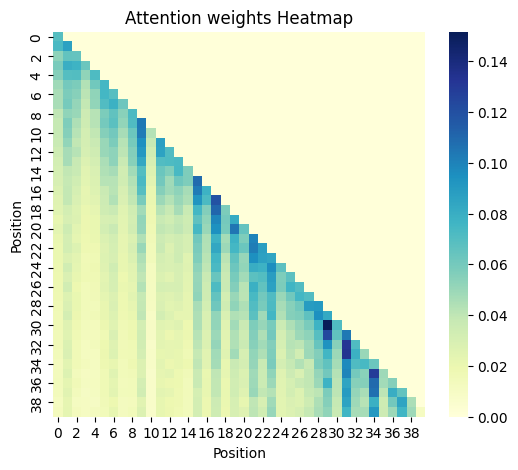

In [31]:
# Построение heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(attn_map[-40:, -40:], cmap='YlGnBu', cbar=True)

plt.xlabel('Position')
plt.ylabel('Position')
plt.title('Attention weights Heatmap')
plt.show()

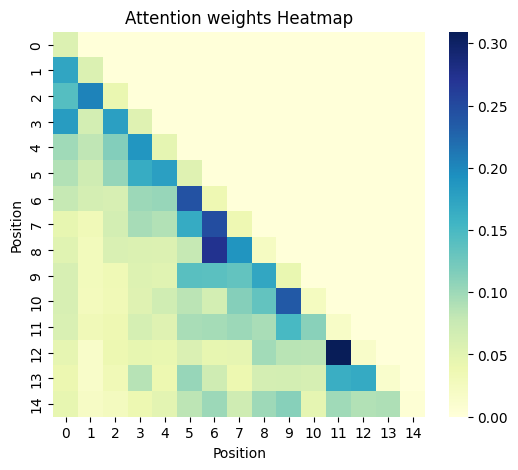

In [77]:
# Построение heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(attn_map[-15:, -15:], cmap='YlGnBu', cbar=True)

plt.xlabel('Position')
plt.ylabel('Position')
plt.title('Attention weights Heatmap')
plt.show()

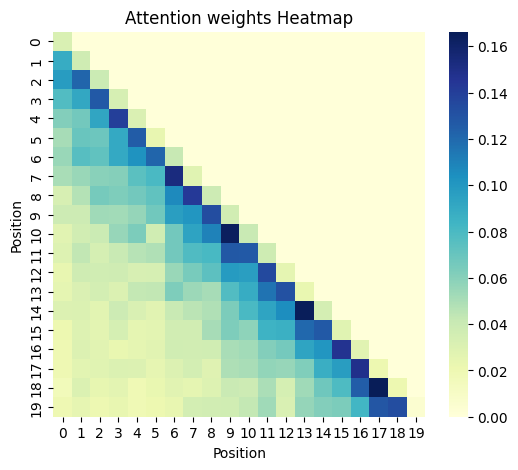

In [183]:
# Построение heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(attn_map[-20:, -20:], cmap='YlGnBu', cbar=True)

plt.xlabel('Position')
plt.ylabel('Position')
plt.title('Attention weights Heatmap')
plt.show()

In [ ]:
sum(counts_100)

In [ ]:
for i in range(30):
    div = attn_map.sum(axis=1)[i]
    attn_map[i, :] = attn_map[i, :] / div

In [ ]:
# Построение heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(attn_map, cmap='YlGnBu', cbar=True)

plt.xlabel('Position')
plt.ylabel('Time Step')
plt.title('Example Attention Heatmap')
plt.show()

In [ ]:
users, counts = np.unique(train_df['user_id'], return_counts=True)
user_counts = {users[i]: counts[i] for i in range(len(users))}
counts_100 = np.unique(counts, return_counts=True)
length_counts = counts_100[1]
length_counts[99] = sum(counts_100[1][99:])
length_counts = length_counts[:100]
length_counts[:2] = [0, 0] 

In [ ]:
length_counts

In [ ]:
n_valid_weights = np.array([sum(length_counts[-(i+1):]) for i in range(len(length_counts))])
n_valid_weights

In [ ]:
attn_map[99, :] / n_valid_weights

In [52]:
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/lightning_logs/version_0/hparams.yaml
/kaggle/working/lightning_logs/version_0/recos_cut_20.pkl
/kaggle/working/lightning_logs/version_0/recos.pkl
/kaggle/working/lightning_logs/version_0/metrics.csv
/kaggle/working/lightning_logs/version_0/checkpoints/epoch=9-NDCG@5=0.17.ckpt
/kaggle/working/lightning_logs/version_0/checkpoints/last_epoch.ckpt


In [83]:
loaded = SASRecModel.load_from_checkpoint('/kaggle/working/lightning_logs/version_3/checkpoints/last_epoch.ckpt')

In [ ]:
# model.backbone.transformer_layers.get_attention_weights()
attention_weights = loaded.torch_model.transformer_layers.get_attention_weights()

In [ ]:
attn_map = attention_weights[:,:,:].mean(dim=0).cpu()
attn_map = attn_map[-20:, -20:]

In [ ]:
attn_map_norm = np.zeros_like(attn_map)
for i in range(15):
    div = attn_map.sum(axis=1)[i]
    attn_map_norm[i, :] = attn_map[i, :] / div

In [ ]:
# Построение heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(attn_map, cmap='YlGnBu', cbar=True)

plt.xlabel('Номер товара в истории')
plt.ylabel('Длина истории')
plt.title('Attention Heatmap')
plt.show()

In [ ]:
n_valid_weights[::-1]

In [62]:
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/lightning_logs/version_0/hparams.yaml
/kaggle/working/lightning_logs/version_0/recos_cut_20.pkl
/kaggle/working/lightning_logs/version_0/attn_map.pkl
/kaggle/working/lightning_logs/version_0/recos.pkl
/kaggle/working/lightning_logs/version_0/metrics.csv
/kaggle/working/lightning_logs/version_0/checkpoints/epoch=9-NDCG@5=0.17.ckpt
/kaggle/working/lightning_logs/version_0/checkpoints/last_epoch.ckpt


In [63]:
!zip -r custom_sasrec.zip /kaggle/working/lightning_logs/version_0

  adding: kaggle/working/lightning_logs/version_0/ (stored 0%)
  adding: kaggle/working/lightning_logs/version_0/hparams.yaml (deflated 77%)
  adding: kaggle/working/lightning_logs/version_0/recos_cut_20.pkl (deflated 74%)
  adding: kaggle/working/lightning_logs/version_0/attn_map.pkl (deflated 54%)
  adding: kaggle/working/lightning_logs/version_0/recos.pkl (deflated 74%)
  adding: kaggle/working/lightning_logs/version_0/metrics.csv (deflated 40%)
  adding: kaggle/working/lightning_logs/version_0/checkpoints/ (stored 0%)
  adding: kaggle/working/lightning_logs/version_0/checkpoints/epoch=9-NDCG@5=0.17.ckpt (deflated 10%)
  adding: kaggle/working/lightning_logs/version_0/checkpoints/last_epoch.ckpt (deflated 10%)


In [64]:
from IPython.display import FileLink
FileLink(r'custom_sasrec.zip')

/kaggle/working/custom_sasrec.zip

In [34]:
import pandas as pd

import pandas as pd

def remove_last_r_actions(df: pd.DataFrame, r: int) -> pd.DataFrame:
    """
    Удаляет последние r действий для каждого пользователя.
    
    Параметры:
    - df: DataFrame, содержащий пользовательские действия. 
          Должен содержать колонки 'user_id' и 'timestamp'.
    - r: int, количество последних действий на пользователя, которые нужно удалить.
    
    Возвращает:
    - DataFrame без последних r действий для каждого пользователя.
    """
    # Сортируем по пользователю и времени
    df_sorted = df.sort_values(by=['user_id', 'datetime'])
    # Нумеруем действия для каждого пользователя
    df_sorted['action_number'] = df_sorted.groupby('user_id').cumcount()
    # Считаем общее количество действий на пользователя
    df_sorted['total_actions'] = df_sorted.groupby('user_id')['action_number'].transform('max')
    # Оставляем только те, где порядковый номер < (всего - r)
    filtered_df = df_sorted[df_sorted['action_number'] < df_sorted['total_actions'] - r + 1]
    return filtered_df.drop(columns=['action_number', 'total_actions'])

In [ ]:
user_counts = train_df['user_id'].value_counts()
TEST_USERS = user_counts[user_counts >= 15].index[:1000]

In [36]:
total_recos = []
for i in tqdm(range(10)):
    current_df = remove_last_r_actions(df=train_df, r=i)
    features_names = ['Category', 'Delivery', 'Brand', 'Pet']
    current_dataset = Dataset.construct(
        interactions_df=current_df,
        item_features_df=items,
        cat_item_features=features_names,
    )
    current_recos = model.recommend(TEST_USERS, current_dataset, k=5, filter_viewed=False)
    total_recos.append(current_recos)

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


In [38]:
pd.concat(total_recos, axis=0).to_pickle('/kaggle/working/last_10_recos.pkl')

In [ ]:
1